In [1]:
import torch
import numpy as np
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from ultralytics import YOLO

import cv2
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread("../../assets/test/dashcam-train(550e9f1b-b49b2afa).jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


0: 384x640 6 cars, 1 bus, 1 truck, 3 traffic lights, 254.2ms
Speed: 2.7ms preprocess, 254.2ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


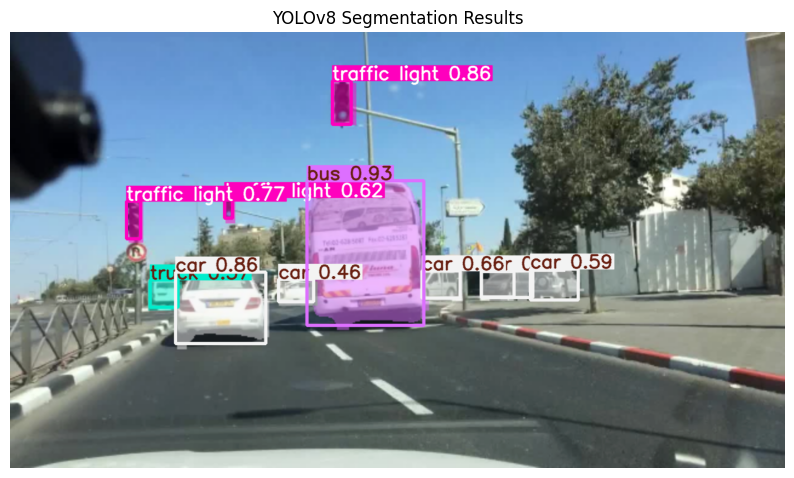

In [3]:
model1 = YOLO("Pre-trained Models/yolov8m-seg.pt")  # yolov8n-seg.pt # yolov8s-seg.pt # yolov8l-seg.pt # yolov8x-seg.pt
results1 = model1(image)[0]

plt.figure(figsize=(10, 6))
plt.imshow(results1.plot())
plt.title("YOLOv8 Segmentation Results")
plt.axis('off')
plt.show()

In [5]:
segformer_model = "nvidia/segformer-b2-finetuned-cityscapes-1024-1024"
processor = SegformerImageProcessor()
model2 = SegformerForSemanticSegmentation.from_pretrained(segformer_model)

Original image size: 1280x720
Logits shape: torch.Size([1, 19, 128, 128])


C:\Users\porip\AppData\Local\Temp\ipykernel_5472\1702247323.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(cityscapes_labels))


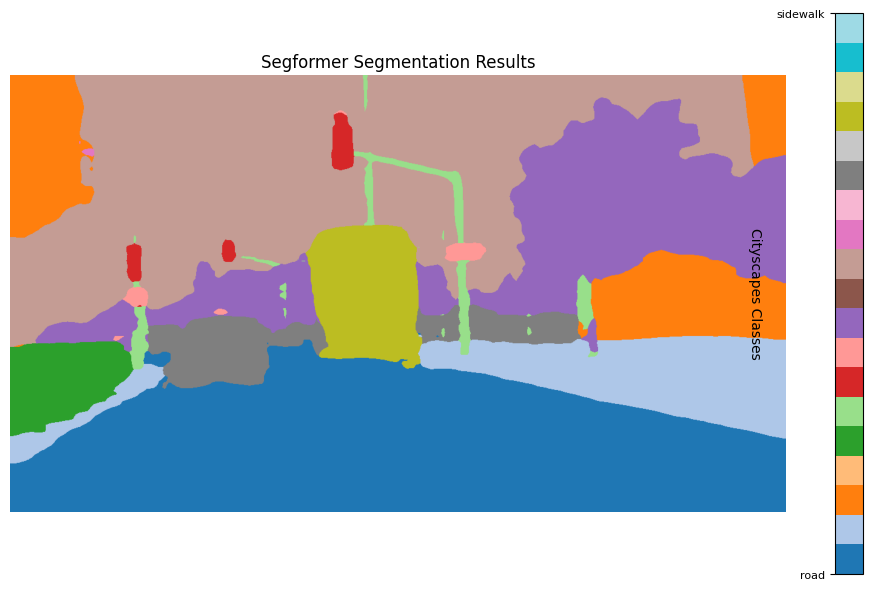

In [ ]:
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model2(**inputs)
logits = outputs.logits  # [1, num_classes, height, width]

# Get original image size from numpy array shape
original_height, original_width = image.shape[:2]  # (height, width)
print(f"Original image size: {original_width}x{original_height}")
print(f"Logits shape: {logits.shape}")

# Upsample logits to original image size
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=(original_height, original_width),  # (height, width)
    mode='bilinear',
    align_corners=False
)

preds = torch.argmax(upsampled_logits, dim=1).cpu().numpy()[0]

cityscapes_labels = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

# Create a color map for visualization
colors = plt.cm.get_cmap('tab20', len(cityscapes_labels))
def decode_segmentation(preds, labels, colors):
    color_map = {i: colors(i) for i in range(len(labels))}
    seg_image = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)
    
    for label_idx, color in color_map.items():
        mask = preds == label_idx
        seg_image[mask] = (np.array(color[:3]) * 255).astype(np.uint8)  # Convert to RGB
    
    return seg_image
segmentation_image = decode_segmentation(preds, cityscapes_labels, colors)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(segmentation_image)
ax.set_title("Segformer Segmentation Results")
ax.axis('off')
plt.tight_layout()
# Add color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colors), ax=ax, ticks=range(len(cityscapes_labels)))
cbar.ax.set_yticklabels(cityscapes_labels)
cbar.set_label('Cityscapes Classes', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')
plt.show()